<a href="https://colab.research.google.com/github/revysatyagunawan/Tugas_PCD_RevySatyaGunawan_24_538296_PA_22835/blob/main/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas 3 Pengolahan Citra Digital: Morphological Processing
### Nama: Revy Satya Gunawan
### NIM: 24/538296/PA/22835

---

## Segmentation ##
Sebelum kita melakukan morphological processing, kita akan melakukan segmentation terlebih dahulu pada citra kita. Metode segmentation yang digunakan di sini adalah Otsu's Method.


--2025-11-07 11:28:59--  https://cdn.download.ams.birds.cornell.edu/api/v1/asset/170576681/320
Resolving cdn.download.ams.birds.cornell.edu (cdn.download.ams.birds.cornell.edu)... 13.226.52.16, 13.226.52.13, 13.226.52.40, ...
Connecting to cdn.download.ams.birds.cornell.edu (cdn.download.ams.birds.cornell.edu)|13.226.52.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19489 (19K) [image/jpeg]
Saving to: ‘citra.jpg’

citra.jpg           100%[===================>]  19.03K  --.-KB/s    in 0.001s  

2025-11-07 11:28:59 (12.8 MB/s) - ‘citra.jpg’ saved [19489/19489]

Citra sebelum segmentation


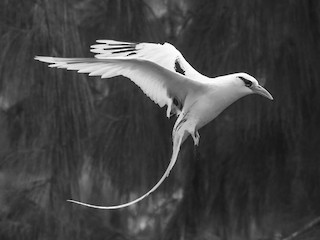


Tresholding optimal Otsu: 115
Citra setelah segmentation dengan Otsu's Method


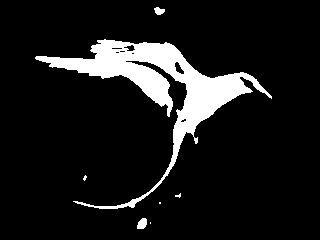

In [1]:
import numpy as np
import cv2 as cv
import os
from google.colab.patches import cv2_imshow

# Unduh Citra
!wget "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/170576681/320" -O citra.jpg

# Read citra yang diunduh
img = cv.imread('citra.jpg', cv.IMREAD_GRAYSCALE)

print("Citra sebelum segmentation")
cv2_imshow(img)

blur = cv.GaussianBlur(img,(5,5),0)

# Normalisasikan histogram dan cari fungsi distribusi kumulatifnya
hist = cv.calcHist([blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.sum()
Q = hist_norm.cumsum()

bins = np.arange(256)

fn_min = np.inf
thresh = -1

#Otsu's Method
for i in range(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilitas

    q1 = Q[i-1]
    q2 = 1.0 - q1

    if q1 < 1.e-6 or q2 < 1.e-6:
        continue

    b1,b2 = np.hsplit(bins,[i]) # bobot

    # Mencari means dan variance
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

    # Minimalisasi
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

print(f"\nTresholding optimal Otsu: {thresh}")

# Terapkan tresholding kita
otsu_img = np.zeros_like(blur)
otsu_img[blur >= thresh] = 255

print("Citra setelah segmentation dengan Otsu's Method")
cv2_imshow(otsu_img)



## Morphological Processing ##
Berdasrakan hasil segmentation tersebut, kita memiliki suatu masalah. Terdapat lubang/area hitam kecil pada objek burung yang seharusnya menjadi bagian dari burung (berwarna putih).

Oleh karena itu, ada dua morphological process yang cocok, yaitu dilation dan closing (dilation yang dilanjutkan dengan erosion).

Jadi, pada akhirnya kita akan membandingkan tiga citra setelah segmentation:
1. yang tanpa morphological processing,
2. yang dilanjutkan dengan dilation,
3. yang dilanjutkan dengan closing (dilation + erosion).


 Citra setelah dilation:


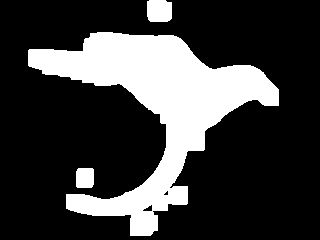


Citra Setelah (dilation + erosion) closing


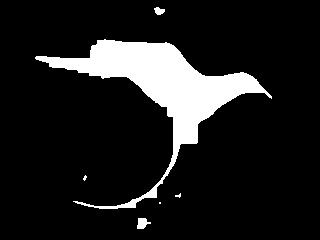

In [2]:
kernel = np.ones((15,15), np.uint8)

# Hitung padding
k_h, k_w = kernel.shape
pad_y = k_h // 2
pad_x = k_w // 2

# Buat citra output untuk dilation
dilation_img = np.zeros_like(otsu_img)

# Tambahkan padding pada hasil segmentasi
padded_dilation_img = np.pad(otsu_img, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)

# Dilation
for y in range(otsu_img.shape[0]):
    for x in range(otsu_img.shape[1]):
        # Dapatkan window
        window = padded_dilation_img[y : y + k_h, x : x + k_w]

        # Terapkan Dilation
        dilation_img[y, x] = np.max(window)

print("\n Citra setelah dilation:")
cv2_imshow(dilation_img)

# Sekarang kita lakukan erosion untuk menyelesaikan closing

# Buat citra output untuk hasil closing
closing_img = np.zeros_like(dilation_img)

# Tambahkan padding ke *hasil dilation*
padded_closing_img = np.pad(dilation_img, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)

# Erosion untuk menyelesaikan closing
for y in range(dilation_img.shape[0]):
    for x in range(dilation_img.shape[1]):
        # Dapatkan window
        window = padded_closing_img[y : y + k_h, x : x + k_w]

        # Terapkan Erosion
        closing_img[y, x] = np.min(window)

print("\nCitra Setelah (dilation + erosion) closing")
cv2_imshow(closing_img)

## Analisis dan Kesimpulan ##
Berdasarkan morphological process yang sudah dilakukan, bisa dilihat bahwa dilation mampu menutup lubang/noise berwarna hitam pada tubuh burung, tetapi menghilangkan detail bentuk objek kita.

Oleh karena itu, dilation saja tidaklah cukup sehingga kita perlu menambahkan erosion untuk mendapatkan kembali detail bentuk objek kita. Oleh karena itu, kita sama saja melakukan closing.

Sebagai kesimpulan, bisa dilihat bahwa baik hasil segmentation tanpa closing maupun dengan closing memiliki bentuk objek yang detail. Namun, pada hasil closing, noise/lubang/area hitam pada tubuh burung sudah tidak ada. Jadi, segmentation yang dilanjutkan dengan closing memiliki hasil yang terbaik pada kasus kita.

---